In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Data Preparation

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-1.4/consolidated_data_v2.csv')
print(df.head())


   Unnamed: 0  SUBJECT_ID  HADM_ID  ICUSTAY_ID  Vent_Dur_Min  \
0           0          36   165660    241249.0        5714.0   
1           1         124   138376    256064.0       28000.0   
2           2         165   170252    247247.0         854.0   
3           3         188   123860    213646.0        2701.0   
4           4         188   132401    246866.0        9635.0   

  Vent_Duration_Cat                     LABEL ADMISSION_TYPE GENDER  \
0      Sig_Over_Day      Invasive Ventilation       ELECTIVE      M   
1      Sig_Over_Day      Invasive Ventilation      EMERGENCY      M   
2     Mod_Under_Day  Non-invasive Ventilation      EMERGENCY      M   
3      Sig_Over_Day      Invasive Ventilation      EMERGENCY      M   
4      Sig_Over_Day      Invasive Ventilation      EMERGENCY      M   

   Age_Admission  ... 224093_Position  224168_Parameters Checked  \
0           72.7  ...          Supine                        1.0   
1           75.1  ...       Left Side               

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import tensorflow as tf


# --- Separate Features (X) and Target (y) ---
# We will predict 'Vent_Dur_Min'
X = df.drop(columns=['Vent_Dur_Min', 'Vent_Duration_Cat', 'LABEL', 'Unnamed: 0'])
y = df['Vent_Dur_Min']

# --- Identify Categorical and Numerical Features ---
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

# --- Create a Preprocessing Pipeline ---
# This handles one-hot encoding for categorical data and scaling for numerical data
preprocessor = make_column_transformer(
   (OneHotEncoder(handle_unknown='ignore'), categorical_features),
   (StandardScaler(), numerical_features)
)

# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Apply Preprocessing ---
# Fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Build and Train the Neural Network

### Evaluate Model Performance

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from tensorflow.keras.utils import to_categorical

# --- 1. Load Data and Prepare Features ---
# Assuming 'df' is your DataFrame
# For this example, let's create a dummy file and load it
# df = pd.read_csv('/path/to/your/ventilator_data.csv')

# --- Separate Features (X) and Target (y) ---
# X remains the same, but y is now 'Vent_Duration_Cat'
X = df.drop(columns=['Vent_Dur_Min', 'Vent_Duration_Cat', 'LABEL', 'Unnamed: 0'])
y_labels = df['Vent_Duration_Cat']

# --- 2. Encode the Categorical Target (y) ---
# First, convert string labels to integers
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y_labels)

# Then, one-hot encode the integers
y = to_categorical(y_integers)

# Get the number of classes for the model's output layer
num_classes = y.shape[1]
print(f"Number of classes to predict: {num_classes}")
print(f"Class labels: {label_encoder.classes_}")

# --- Prepare Features (Same as before) ---
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

preprocessor = make_column_transformer(
   (OneHotEncoder(handle_unknown='ignore'), categorical_features),
   (StandardScaler(), numerical_features)
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- 3. Build and Compile the Classification Model ---
model_clf = tf.keras.Sequential([
   tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train_processed.shape[1]]),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dropout(0.2),
   # MODIFIED: Output layer for classification
   tf.keras.layers.Dense(num_classes, activation='softmax')
])

# MODIFIED: Compile with new loss function and add 'accuracy' metric
model_clf.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

model_clf.summary()

# --- 4. Train and Evaluate the Model ---
history = model_clf.fit(
   X_train_processed,
   y_train,
   validation_split=0.2,
   epochs=100,
   batch_size=32,
   verbose=0 # Set to 1 for progress updates
)

print("\n--- Classification Model Evaluation ---")
loss, accuracy = model_clf.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Number of classes to predict: 2
Class labels: ['Mod_Under_Day' 'Sig_Over_Day']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,810 (186.76 KB)

 Trainable params: 47,810 (186.76 KB)

 Non-trainable params: 0 (0.00 B)


--- Classification Model Evaluation ---
Test Accuracy: 67.99%


### CONFUSION MATRIX PLOT




53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
--- Classification Report ---
               precision    recall  f1-score   support

Mod_Under_Day       0.68      0.67      0.68       845
 Sig_Over_Day       0.68      0.69      0.68       848

     accuracy                           0.68      1693
    macro avg       0.68      0.68      0.68      1693
 weighted avg       0.68      0.68      0.68      1693


--- Confusion Matrix ---


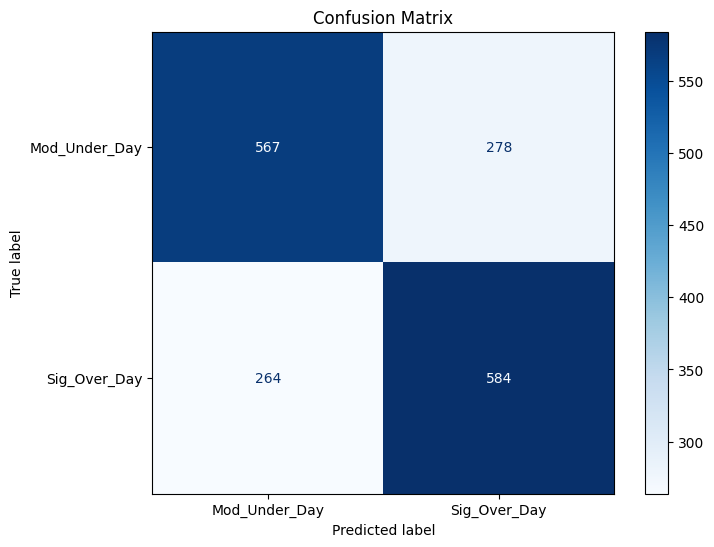

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Make predictions on the test data ---
y_pred_probs = model_clf.predict(X_test_processed)
# Convert probabilities to class labels (0 or 1)
y_pred = np.argmax(y_pred_probs, axis=1)
# We also need to get the original test labels (not one-hot encoded)
y_test_labels = np.argmax(y_test, axis=1)

# --- 1. Print the Classification Report ---
# This shows precision, recall, and f1-score for each class
print("--- Classification Report ---")
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# --- 2. Display the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_labels, y_pred)

# Use ConfusionMatrixDisplay for a nice plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Summary

### Precision (0.68 for both):
When the model predicts a category, it is correct about 68% of the time.

### Recall (0.67-0.69):

The model successfully identifies about 67-69% of all the actual patients in each category.

### F1-Score (0.68 for both):

This is the harmonic mean of precision and recall, providing a single score that balances both metrics. An F1-score of 0.68 indicates a reasonable, but not yet strong, performance.

### Confusion Matrix:

The plot visually confirms the balanced performance. The model correctly identified a similar number of patients for both classes (True Positives, top-left and bottom-right) and made a similar number of errors for both classes (False Positives and False Negatives, top-right and bottom-left).
In short, your model is a fair, balanced classifier, but it still has significant room for improvement to be clinically useful.

### Model Architecture Visualization

In [ ]:
!pip install pydot graphviz

Successfully saved model architecture plot to 'model_architecture.png'.


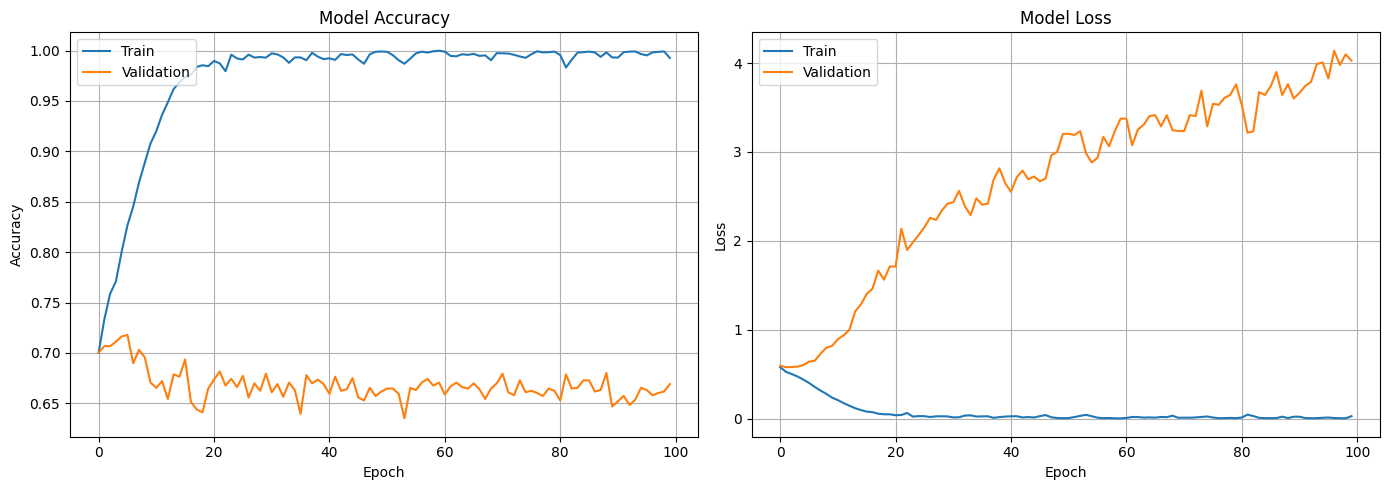

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# --- 1. Visualize Model Architecture ---
# This saves the model's structure to a file named 'model_architecture.png'
try:
   plot_model(model_clf, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
   print("Successfully saved model architecture plot to 'model_architecture.png'.")
   # You can display this image in a Jupyter Notebook like this:
   # from IPython.display import Image
   # Image(retina=True, filename='model_architecture.png')
except ImportError as e:
   print(f"Plotting error: {e}. Please install pydot and graphviz.")


# --- 2. Visualize Training History ---
# The 'history' object was returned by the model.fit() method

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Model Accuracy (Left Plot):

The blue Train accuracy line quickly goes to nearly 100%, meaning the model has memorized the training examples. However, the orange Validation accuracy line stagnates at a much lower level (around 65-70%). This gap shows that the model's knowledge doesn't apply well to new data.

### Model Loss (Right Plot):

This is the most telling sign. The blue Train loss drops to almost zero, as expected. In contrast, the orange Validation loss steadily increases. This divergence is the definitive symptom of overfitting; as the model gets better at fitting the training data, it gets progressively worse at handling the validation data.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from tensorflow.keras.utils import to_categorical

# --- 1. Load Data and Prepare Features ---
# Assuming 'df' is your DataFrame
# For this example, let's create a dummy file and load it
# df = pd.read_csv('/path/to/your/ventilator_data.csv')

# --- Separate Features (X) and Target (y) ---
# X remains the same, but y is now 'Vent_Duration_Cat'
X = df.drop(columns=['Vent_Dur_Min', 'Vent_Duration_Cat', 'LABEL', 'Unnamed: 0'])
y_labels = df['Vent_Duration_Cat']

# --- 2. Encode the Categorical Target (y) ---
# First, convert string labels to integers
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y_labels)

# Then, one-hot encode the integers
y = to_categorical(y_integers)

# Get the number of classes for the model's output layer
num_classes = y.shape[1]
print(f"Number of classes to predict: {num_classes}")
print(f"Class labels: {label_encoder.classes_}")

# --- Prepare Features (Same as before) ---
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

preprocessor = make_column_transformer(
   (OneHotEncoder(handle_unknown='ignore'), categorical_features),
   (StandardScaler(), numerical_features)
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- 3. Build and Compile the Classification Model ---
model_clf = tf.keras.Sequential([
   tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train_processed.shape[1]]),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dropout(0.2),
   # MODIFIED: Output layer for classification
   tf.keras.layers.Dense(num_classes, activation='softmax')
])

# MODIFIED: Compile with new loss function and add 'accuracy' metric
model_clf.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

model_clf.summary()

# Define the callback
early_stopping = EarlyStopping(
   monitor='val_loss', # Monitor validation loss
   patience=10,        # Stop after 10 epochs with no improvement
   restore_best_weights=True # Restore model weights from the best epoch
)

# --- 4. Train and Evaluate the Model ---
history = model_clf.fit(
   X_train_processed,
   y_train,
   validation_split=0.2,
   epochs=100,
   batch_size=32,
   verbose=0, # Set to 1 for progress updates
   callbacks=[early_stopping] # Add the callback here
)

print("\n--- Classification Model Evaluation ---")
loss, accuracy = model_clf.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Number of classes to predict: 2
Class labels: ['Mod_Under_Day' 'Sig_Over_Day']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,810 (186.76 KB)

 Trainable params: 47,810 (186.76 KB)

 Non-trainable params: 0 (0.00 B)


--- Classification Model Evaluation ---
Test Accuracy: 73.30%


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
--- Classification Report ---
               precision    recall  f1-score   support

Mod_Under_Day       0.79      0.64      0.70       845
 Sig_Over_Day       0.70      0.83      0.76       848

     accuracy                           0.73      1693
    macro avg       0.74      0.73      0.73      1693
 weighted avg       0.74      0.73      0.73      1693


--- Confusion Matrix ---


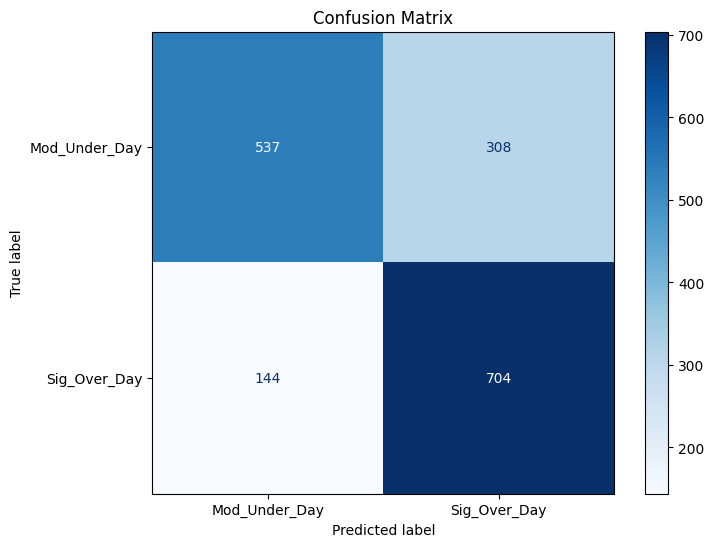

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Make predictions on the test data ---
y_pred_probs = model_clf.predict(X_test_processed)
# Convert probabilities to class labels (0 or 1)
y_pred = np.argmax(y_pred_probs, axis=1)
# We also need to get the original test labels (not one-hot encoded)
y_test_labels = np.argmax(y_test, axis=1)

# --- 1. Print the Classification Report ---
# This shows precision, recall, and f1-score for each class
print("--- Classification Report ---")
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# --- 2. Display the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_labels, y_pred)

# Use ConfusionMatrixDisplay for a nice plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Successfully saved model architecture plot to 'model_architecture.png'.


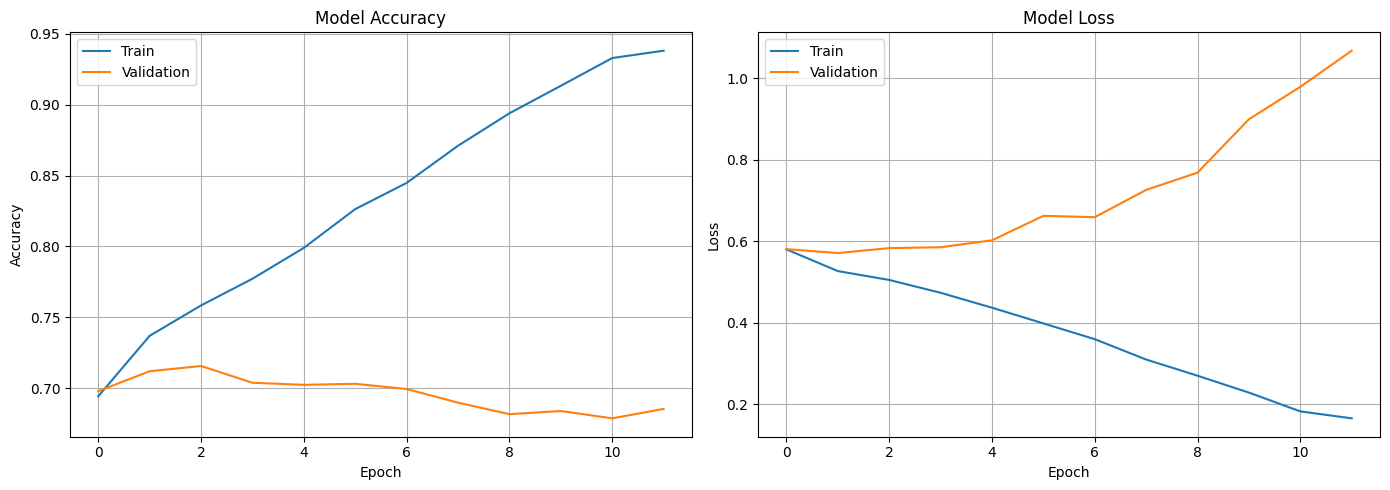

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# --- 1. Visualize Model Architecture ---
# This saves the model's structure to a file named 'model_architecture.png'
try:
   plot_model(model_clf, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
   print("Successfully saved model architecture plot to 'model_architecture.png'.")
   # You can display this image in a Jupyter Notebook like this:
   # from IPython.display import Image
   # Image(retina=True, filename='model_architecture.png')
except ImportError as e:
   print(f"Plotting error: {e}. Please install pydot and graphviz.")


# --- 2. Visualize Training History ---
# The 'history' object was returned by the model.fit() method

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()